# Evaluation of Graph Transformer (GTP) Baseline Model Using Quadratic Weighted Kappa

This notebook evaluates the performance of our Graph Transformer (GTP) model on the PANDA prostate cancer grading task.  
The objective of this evaluation is to obtain a reliable baseline performance using **Quadratic Weighted Kappa (QWK)**, a metric commonly used in medical image grading tasks where the classes represent *ordered severity levels*.

In the PANDA dataset (ISUP grading), misclassifying a sample by one grade (e.g., 1 → 2) is less severe than misclassifying it by two grades (e.g., 0 → 2).  
QWK captures this idea by penalizing classification errors proportionally to their ordinal distance.  
As a result, QWK provides a more clinically meaningful performance measure than simple accuracy.

The notebook performs the following steps:

1. **Load the validation set** and graph representations for each Whole Slide Image (WSI).  
2. **Compute class weights** from the training set for interpretability and model consistency.  
3. **Load the trained GTP checkpoint**, handling optional training-time keys in the state dictionary.  
4. **Run inference** on each graph, capturing logits through forward hooks.  
5. **Generate predictions** and compare them to ground truth labels.  
6. **Compute key evaluation metrics**, including:
   - Quadratic Weighted Kappa (QWK)  
   - Overall accuracy  
   - Confusion matrix  
   - Per-class precision/recall/F1 scores  
7. **Summarize baseline performance** and compute the target values required for grade improvement (B+, A), as defined in the project rubric.

This baseline evaluation provides a reference point against which future model improvements—such as class-balanced losses, graph augmentation, or enhanced feature embeddings—can be measured.


In [2]:
#!/usr/bin/env python3
"""
GTP Model Evaluation - QWK, AUROC, AUPRC, F1, Confusion Matrix
"""
import torch
import numpy as np
from sklearn.metrics import (
    cohen_kappa_score, confusion_matrix, classification_report,
    accuracy_score, roc_auc_score, f1_score, average_precision_score
)
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
from utils.dataset import GraphDataset
from helper import collate
from models.GraphTransformer import Classifier
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# CONFIGURATION - CHANGE THESE FOR DIFFERENT MODELS
# ============================================================

'''
CONFIG = {
    'name': 'SimCLR',
    'checkpoint': './graph_transformer/saved_models/simclr_transformer_model.pth',
    'data_path': './feature_extractor/graphs_simclr/panda',
    'n_features': 512,
    'n_class': 3,
    'val_file': './scripts/test_set.txt',
}



CONFIG = {
    'name': 'Phikon',
    'checkpoint': './graph_transformer/saved_models/phikon_transformer_model.pth',
    'data_path': './feature_extractor/graphs_phikon/panda',
    'n_features': 768,
    'n_class': 3,
    'val_file': './scripts/test_set.txt',
}


CONFIG = {
    'name': 'ImageNet ResNet50',
    'checkpoint': './graph_transformer/saved_models/main_baseline.pth',
    'data_path': './feature_extractor/graphs_imagenet/panda',
    'n_features': 2048,
    'n_class': 3,
    'val_file': './scripts/test_set.txt',
}
'''
CONFIG = {
    'name': 'GAT Model',
    'checkpoint': './graph_transformer/saved_models/gat/gat_phikon_model.pth',
    'data_path': './feature_extractor/graphs_phikon/panda',
    'n_features': 768,
    'n_class': 3,
    'val_file': './scripts/test_set.txt',
}



# ============================================================
# LOAD DATA & MODEL
# ============================================================
print(f"{'='*60}\nEvaluating: {CONFIG['name']}\n{'='*60}\n")

with open(CONFIG['val_file'], 'r') as f:
    val_ids = [line.strip() for line in f if line.strip()]

dataset = GraphDataset(CONFIG['data_path'], val_ids, site='panda')
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate, num_workers=0, shuffle=False)
print(f"Validation samples: {len(dataset)}")

model = Classifier(n_class=CONFIG['n_class'], n_features=CONFIG['n_features'])
state_dict = torch.load(CONFIG['checkpoint'], map_location=device)
state_dict = OrderedDict((k.replace('module.', ''), v) for k, v in state_dict.items())
model.load_state_dict(state_dict, strict=False)
model = model.to(device).eval()

logits_list = []
def hook_fn(module, input, output):
    if hasattr(output, 'shape') and len(output.shape) == 2 and output.shape[1] == CONFIG['n_class']:
        logits_list.append(output.detach().cpu())

for module in model.modules():
    if isinstance(module, torch.nn.Linear):
        module.register_forward_hook(hook_fn)

# ============================================================
# RUN EVALUATION
# ============================================================
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for i, sample in enumerate(dataloader):
        if sample is None:
            continue
        try:
            img = sample["image"][0].unsqueeze(0).float().to(device)
            adj = sample["adj_s"][0].unsqueeze(0).float().to(device)
            label = sample["label"][0]
            mask = torch.ones(1, img.size(1)).to(device)
            label_tensor = torch.tensor([label], dtype=torch.long).to(device)
            
            logits_list.clear()
            model(img, label_tensor, adj, mask)
            
            if logits_list:
                logits = logits_list[-1]
                probs = torch.softmax(logits, dim=1).numpy()[0]
                pred = logits.argmax(1).item()
                
                all_preds.append(pred)
                all_labels.append(label)
                all_probs.append(probs)
                
            if (i + 1) % 200 == 0:
                print(f"Processed {i+1}/{len(dataloader)}")
        except:
            continue

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# ============================================================
# CALCULATE METRICS
# ============================================================
acc = accuracy_score(all_labels, all_preds)
qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
f1 = f1_score(all_labels, all_preds, average='weighted')
f1_macro = f1_score(all_labels, all_preds, average='macro')

# AUROC
try:
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
    auroc_macro = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
except:
    auroc, auroc_macro = None, None

# AUPRC (Average Precision)
try:
    labels_bin = label_binarize(all_labels, classes=[0, 1, 2])
    auprc_per_class = []
    for i in range(CONFIG['n_class']):
        auprc_per_class.append(average_precision_score(labels_bin[:, i], all_probs[:, i]))
    auprc_macro = np.mean(auprc_per_class)
    # Weighted AUPRC
    class_counts = np.bincount(all_labels)
    auprc_weighted = np.average(auprc_per_class, weights=class_counts)
except:
    auprc_per_class, auprc_macro, auprc_weighted = [None]*3, None, None

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])

# ============================================================
# PRINT RESULTS
# ============================================================
print(f"\n{'='*60}")
print(f"RESULTS: {CONFIG['name']}")
print(f"{'='*60}\n")

print(f"Accuracy:        {acc:.4f} ({acc*100:.2f}%)")
print(f"QWK:             {qwk:.4f}")
print(f"F1 (weighted):   {f1:.4f}")
print(f"F1 (macro):      {f1_macro:.4f}")
if auroc:
    print(f"AUROC (weighted): {auroc:.4f}")
    print(f"AUROC (macro):    {auroc_macro:.4f}")
if auprc_macro:
    print(f"AUPRC (weighted): {auprc_weighted:.4f}")
    print(f"AUPRC (macro):    {auprc_macro:.4f}")

print(f"\nPer-Class AUPRC:")
class_names = ['Background', 'Benign', 'Cancerous']
for i, name in enumerate(class_names):
    if auprc_per_class[i]:
        print(f"  {name}: {auprc_per_class[i]:.4f}")

print(f"\nConfusion Matrix:")
print(f"         Pred0  Pred1  Pred2")
for i, row in enumerate(cm):
    print(f"Actual {i}: {row[0]:5d}  {row[1]:5d}  {row[2]:5d}")

print(f"\n{classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1', 'Class 2'], digits=4)}")

# ============================================================
# SUMMARY TABLE (copy-paste ready)
# ============================================================
print(f"\n{'='*60}")
print("SUMMARY (Markdown ready)")
print(f"{'='*60}\n")
print(f"| Metric | Score |")
print(f"|--------|-------|")
print(f"| Accuracy | {acc:.4f} |")
print(f"| QWK | {qwk:.4f} |")
print(f"| F1 (weighted) | {f1:.4f} |")
print(f"| F1 (macro) | {f1_macro:.4f} |")
if auroc:
    print(f"| AUROC (weighted) | {auroc:.4f} |")
    print(f"| AUROC (macro) | {auroc_macro:.4f} |")
if auprc_macro:
    print(f"| AUPRC (weighted) | {auprc_weighted:.4f} |")
    print(f"| AUPRC (macro) | {auprc_macro:.4f} |")

print(f"\n| Class | AUPRC |")
print(f"|-------|-------|")
for i, name in enumerate(class_names):
    if auprc_per_class[i]:
        print(f"| {name} | {auprc_per_class[i]:.4f} |")

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'utils' (most likely due to a circular import)

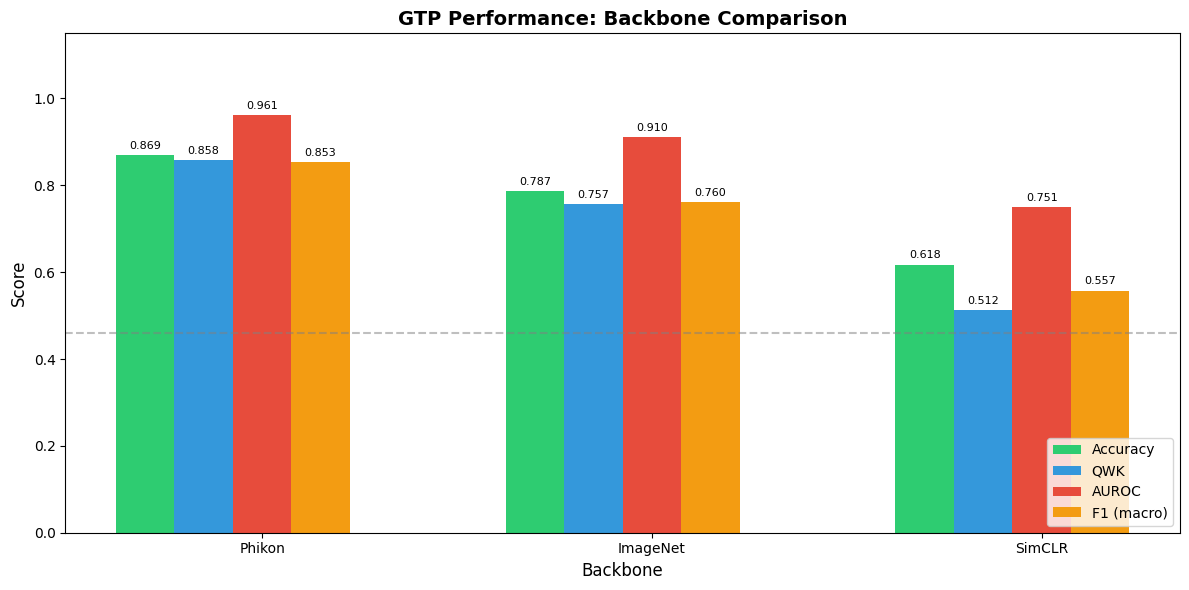

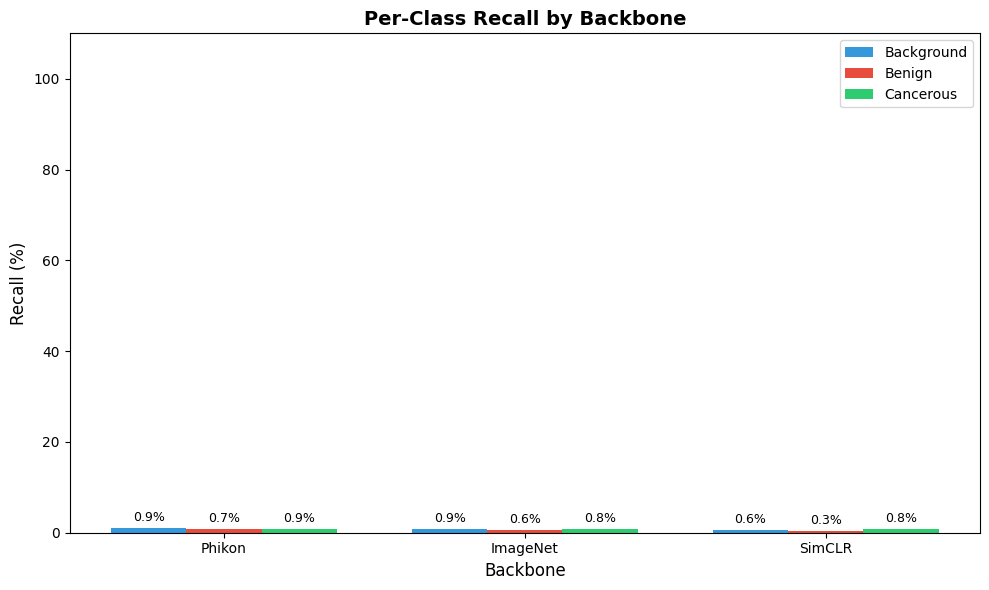

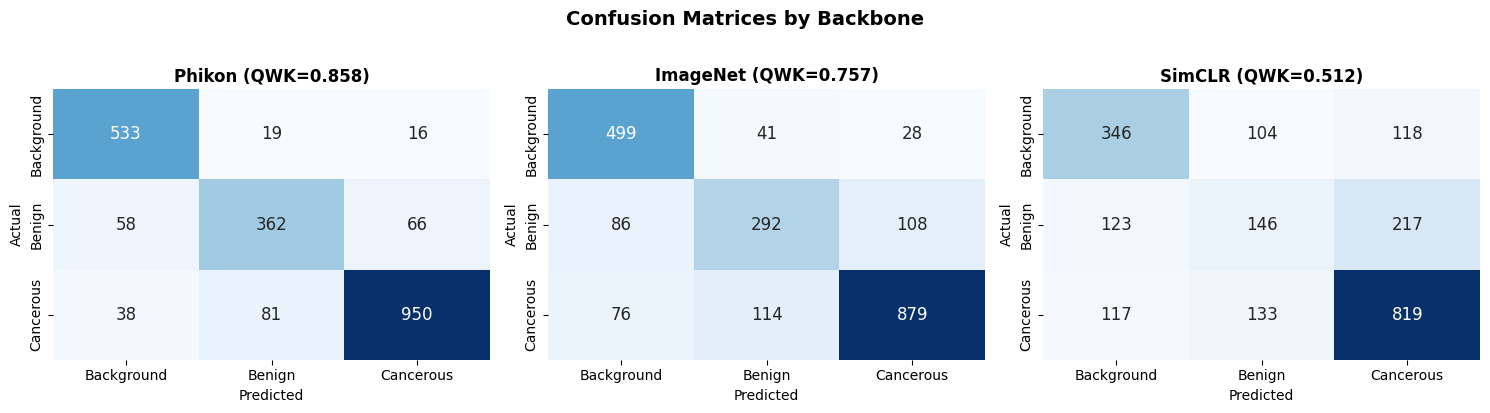

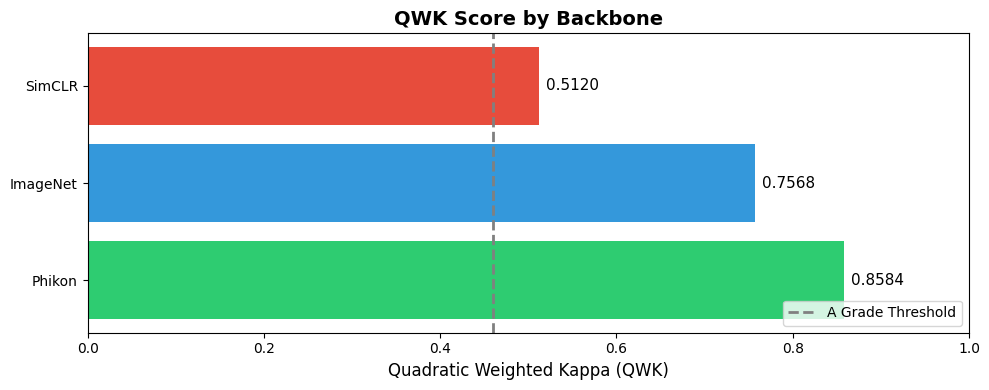

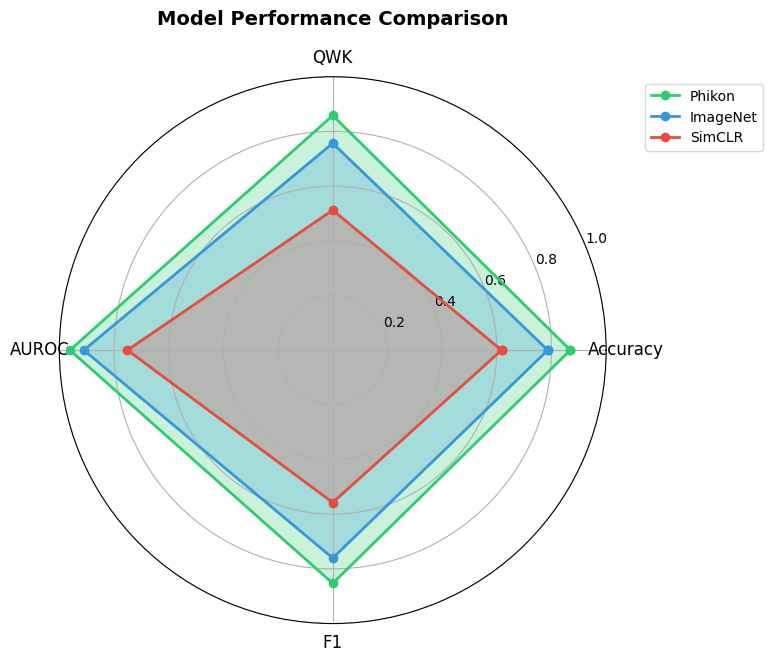

All plots saved!


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================================
# DATA - UPDATE WITH YOUR RESULTS
# ============================================================
models = ['Phikon', 'ImageNet', 'SimCLR']

# Overall metrics
metrics = {
    'Accuracy': [0.8691, 0.7866, 0.6175],
    'QWK': [0.8584, 0.7568, 0.5120],
    'AUROC': [0.9611, 0.9103, 0.7508],
    'AUPRC': [None, None, 0.5715],  # Update with Phikon/ImageNet AUPRC
    'F1 (macro)': [0.8529, 0.7605, 0.5575],
}

# Per-class recall
recall = {
    'Background': [0.938, 0.879, 0.609],
    'Benign': [0.745, 0.601, 0.300],
    'Cancerous': [0.889, 0.822, 0.766],
}

# Per-class AUPRC (update when you have all results)
auprc_per_class = {
    'Background': [None, None, 0.6010],  # Update
    'Benign': [None, None, 0.3374],       # Update
    'Cancerous': [None, None, 0.7759],    # Update
}

# Confusion matrices
cm_phikon = np.array([[533, 19, 16], [58, 362, 66], [38, 81, 950]])
cm_imagenet = np.array([[499, 41, 28], [86, 292, 108], [76, 114, 879]])
cm_simclr = np.array([[346, 104, 118], [123, 146, 217], [117, 133, 819]])

# ============================================================
# PLOT 1: Overall Metrics Comparison (Bar Chart)
# ============================================================
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(models))
width = 0.15
multiplier = 0

colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12']

for i, (metric, values) in enumerate(metrics.items()):
    if None not in values:
        offset = width * multiplier
        bars = ax.bar(x + offset, values, width, label=metric, color=colors[i])
        ax.bar_label(bars, fmt='%.3f', padding=3, fontsize=8)
        multiplier += 1

ax.set_xlabel('Backbone', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('GTP Performance: Backbone Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(models)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.15)
ax.axhline(y=0.46, color='gray', linestyle='--', alpha=0.5, label='A Grade Threshold (QWK)')
plt.tight_layout()
plt.savefig('backbone_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 2: Per-Class Recall (Grouped Bar Chart)
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(models))
width = 0.25

bars1 = ax.bar(x - width, recall['Background'], width, label='Background', color='#3498db')
bars2 = ax.bar(x, recall['Benign'], width, label='Benign', color='#e74c3c')
bars3 = ax.bar(x + width, recall['Cancerous'], width, label='Cancerous', color='#2ecc71')

ax.bar_label(bars1, fmt='%.1f%%', padding=3, fontsize=9)
ax.bar_label(bars2, fmt='%.1f%%', padding=3, fontsize=9)
ax.bar_label(bars3, fmt='%.1f%%', padding=3, fontsize=9)

ax.set_xlabel('Backbone', fontsize=12)
ax.set_ylabel('Recall (%)', fontsize=12)
ax.set_title('Per-Class Recall by Backbone', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 110)
plt.tight_layout()
plt.savefig('per_class_recall.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 3: Confusion Matrices (Side by Side)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cms = [cm_phikon, cm_imagenet, cm_simclr]
titles = ['Phikon (QWK=0.858)', 'ImageNet (QWK=0.757)', 'SimCLR (QWK=0.512)']
class_names = ['Background', 'Benign', 'Cancerous']

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, annot_kws={'size': 12})
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrices by Backbone', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 4: QWK Comparison (Horizontal Bar)
# ============================================================
fig, ax = plt.subplots(figsize=(10, 4))

qwk_values = [0.8584, 0.7568, 0.5120]
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = ax.barh(models, qwk_values, color=colors)
ax.bar_label(bars, fmt='%.4f', padding=5, fontsize=11)
ax.axvline(x=0.46, color='gray', linestyle='--', linewidth=2, label='A Grade Threshold')
ax.set_xlabel('Quadratic Weighted Kappa (QWK)', fontsize=12)
ax.set_title('QWK Score by Backbone', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.0)
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('qwk_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 5: Radar Chart (Spider Plot)
# ============================================================
from math import pi

categories = ['Accuracy', 'QWK', 'AUROC', 'F1']
N = len(categories)

# Values for each model (normalized 0-1)
phikon_vals = [0.8691, 0.8584, 0.9611, 0.8529]
imagenet_vals = [0.7866, 0.7568, 0.9103, 0.7605]
simclr_vals = [0.6175, 0.5120, 0.7508, 0.5575]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the loop

phikon_vals += phikon_vals[:1]
imagenet_vals += imagenet_vals[:1]
simclr_vals += simclr_vals[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, phikon_vals, 'o-', linewidth=2, label='Phikon', color='#2ecc71')
ax.fill(angles, phikon_vals, alpha=0.25, color='#2ecc71')

ax.plot(angles, imagenet_vals, 'o-', linewidth=2, label='ImageNet', color='#3498db')
ax.fill(angles, imagenet_vals, alpha=0.25, color='#3498db')

ax.plot(angles, simclr_vals, 'o-', linewidth=2, label='SimCLR', color='#e74c3c')
ax.fill(angles, simclr_vals, alpha=0.25, color='#e74c3c')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.savefig('radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("All plots saved!")

### GAT Evaluation Script

In [2]:
#!/usr/bin/env python3
"""
GAT Model Evaluation - QWK, AUROC, AUPRC, F1, Confusion Matrix
"""
import torch
import numpy as np
from sklearn.metrics import (
    cohen_kappa_score, confusion_matrix, classification_report,
    accuracy_score, roc_auc_score, f1_score, average_precision_score
)
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
from utils.dataset import GraphDataset
from helper import collate
from models.GAT import GATClassifier
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# CONFIGURATION
# ============================================================
CONFIG = {
    'name': 'GAT Model (Phikon)',
    'checkpoint': './graph_transformer/saved_models/gat/gat_phikon_model.pth',
    'data_path': './feature_extractor/graphs_phikon/panda',
    'n_features': 768,
    'hidden_dim': 64,
    'heads': 4,
    'n_class': 3,
    'test_file': './scripts/test_set.txt',
}

# ============================================================
# LOAD DATA & MODEL
# ============================================================
print(f"{'='*60}\nEvaluating: {CONFIG['name']}\n{'='*60}\n")

with open(CONFIG['test_file'], 'r') as f:
    test_ids = [line.strip() for line in f if line.strip()]

dataset = GraphDataset(CONFIG['data_path'], test_ids, site='panda')
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate, num_workers=0, shuffle=False)
print(f"Test samples: {len(dataset)}")

# Load GAT model
model = GATClassifier(
    n_class=CONFIG['n_class'], 
    n_features=CONFIG['n_features'],
    hidden_dim=CONFIG['hidden_dim'],
    heads=CONFIG['heads']
)

state_dict = torch.load(CONFIG['checkpoint'], map_location=device)

# Handle checkpoint format (might be full checkpoint or just state_dict)
if 'model_state_dict' in state_dict:
    state_dict = state_dict['model_state_dict']

state_dict = OrderedDict((k.replace('module.', ''), v) for k, v in state_dict.items())
model.load_state_dict(state_dict, strict=False)
model = model.to(device).eval()

print(f"Model loaded: {sum(p.numel() for p in model.parameters()):,} parameters")

# ============================================================
# RUN EVALUATION
# ============================================================
all_preds, all_labels, all_probs = [], [], []

print("\nRunning evaluation...")
with torch.no_grad():
    for i, sample in enumerate(dataloader):
        if sample is None:
            continue
        try:
            # Get single graph data
            if isinstance(sample["image"], list):
                img = sample["image"][0].unsqueeze(0).float().to(device)
                adj = sample["adj_s"][0].unsqueeze(0).float().to(device)
                label = sample["label"][0]
            else:
                img = sample["image"].unsqueeze(0).float().to(device)
                adj = sample["adj_s"].unsqueeze(0).float().to(device)
                label = sample["label"]
            
            mask = torch.ones(1, img.size(1)).to(device)
            label_tensor = torch.tensor([label], dtype=torch.long).to(device)
            
            # Forward pass
            pred, _, loss = model(img, label_tensor, adj, mask)
            
            # Get probabilities from the model
            # Re-run to get logits
            model.eval()
            batch_size = img.size(0)
            
            for b in range(batch_size):
                x = img[b]
                a = adj[b]
                m = mask[b] if mask is not None else None
                
                if m is not None:
                    valid_nodes = m.bool()
                    x = x[valid_nodes]
                    a = a[valid_nodes][:, valid_nodes]
                
                edge_index = a.nonzero(as_tuple=False).t().contiguous()
                
                if edge_index.size(1) == 0:
                    continue
                
                # Forward through GAT layers
                x, _ = model.gat1(x, edge_index, return_attention_weights=True)
                x = torch.nn.functional.elu(x)
                x, _ = model.gat2(x, edge_index, return_attention_weights=True)
                x = torch.nn.functional.elu(x)
                x, _ = model.gat3(x, edge_index, return_attention_weights=True)
                
                graph_embed = x.mean(dim=0, keepdim=True)
                logits = model.classifier(graph_embed)
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            
            all_preds.append(pred.cpu().item())
            all_labels.append(label)
            all_probs.append(probs)
                
            if (i + 1) % 200 == 0:
                print(f"Processed {i+1}/{len(dataloader)}")
        except Exception as e:
            continue

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"Evaluated {len(all_preds)} samples")

# ============================================================
# CALCULATE METRICS
# ============================================================
acc = accuracy_score(all_labels, all_preds)
qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
f1 = f1_score(all_labels, all_preds, average='weighted')
f1_macro = f1_score(all_labels, all_preds, average='macro')

# AUROC
try:
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
    auroc_macro = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
except:
    auroc, auroc_macro = None, None

# AUPRC
try:
    labels_bin = label_binarize(all_labels, classes=[0, 1, 2])
    auprc_per_class = []
    for i in range(CONFIG['n_class']):
        auprc_per_class.append(average_precision_score(labels_bin[:, i], all_probs[:, i]))
    auprc_macro = np.mean(auprc_per_class)
    class_counts = np.bincount(all_labels)
    auprc_weighted = np.average(auprc_per_class, weights=class_counts)
except:
    auprc_per_class, auprc_macro, auprc_weighted = [None]*3, None, None

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])

# ============================================================
# PRINT RESULTS
# ============================================================
print(f"\n{'='*60}")
print(f"RESULTS: {CONFIG['name']}")
print(f"{'='*60}\n")

print(f"Accuracy:        {acc:.4f} ({acc*100:.2f}%)")
print(f"QWK:             {qwk:.4f}")
print(f"F1 (weighted):   {f1:.4f}")
print(f"F1 (macro):      {f1_macro:.4f}")
if auroc:
    print(f"AUROC (weighted): {auroc:.4f}")
    print(f"AUROC (macro):    {auroc_macro:.4f}")
if auprc_macro:
    print(f"AUPRC (weighted): {auprc_weighted:.4f}")
    print(f"AUPRC (macro):    {auprc_macro:.4f}")

print(f"\nPer-Class AUPRC:")
class_names = ['Background', 'Benign', 'Cancerous']
for i, name in enumerate(class_names):
    if auprc_per_class[i]:
        print(f"  {name}: {auprc_per_class[i]:.4f}")

print(f"\nConfusion Matrix:")
print(f"           Pred0  Pred1  Pred2")
for i, row in enumerate(cm):
    print(f"Actual {i}:  {row[0]:5d}  {row[1]:5d}  {row[2]:5d}")

print(f"\n{classification_report(all_labels, all_preds, target_names=['Background', 'Benign', 'Cancerous'], digits=4)}")

# ============================================================
# SUMMARY
# ============================================================
print(f"\n{'='*60}")
print("SUMMARY (Markdown ready)")
print(f"{'='*60}\n")
print(f"| Metric | Score |")
print(f"|--------|-------|")
print(f"| Accuracy | {acc:.4f} |")
print(f"| QWK | {qwk:.4f} |")
print(f"| F1 (weighted) | {f1:.4f} |")
print(f"| F1 (macro) | {f1_macro:.4f} |")
if auroc:
    print(f"| AUROC (weighted) | {auroc:.4f} |")
    print(f"| AUROC (macro) | {auroc_macro:.4f} |")
if auprc_macro:
    print(f"| AUPRC (weighted) | {auprc_weighted:.4f} |")
    print(f"| AUPRC (macro) | {auprc_macro:.4f} |")

Evaluating: GAT Model (Phikon)

Test samples: 1062
Model loaded: 280,451 parameters

Running evaluation...
Processed 200/1062
Processed 400/1062
Processed 600/1062
Processed 800/1062
Processed 1000/1062
Evaluated 1062 samples

RESULTS: GAT Model (Phikon)

Accuracy:        0.8701 (87.01%)
QWK:             0.8744
F1 (weighted):   0.8726
F1 (macro):      0.8579
AUROC (weighted): 0.9653
AUROC (macro):    0.9638
AUPRC (weighted): 0.9256
AUPRC (macro):    0.9066

Per-Class AUPRC:
  Background: 0.9287
  Benign: 0.8184
  Cancerous: 0.9728

Confusion Matrix:
           Pred0  Pred1  Pred2
Actual 0:    258     23      4
Actual 1:     18    202     23
Actual 2:     13     57    464

              precision    recall  f1-score   support

  Background     0.8927    0.9053    0.8990       285
      Benign     0.7163    0.8313    0.7695       243
   Cancerous     0.9450    0.8689    0.9054       534

    accuracy                         0.8701      1062
   macro avg     0.8514    0.8685    0.8579    